In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

# 데이터 병합 및 전처리
exchange_rate_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/processed_exchange_rate_data.csv")
kospi_data_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/processed_kospi_data.csv")
market_interest_rate_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/market_interest_rate_processed.csv")
economic_sentiment_index_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/economic_sentiment_index_processed.csv")

# Date 컬럼을 datetime 형식으로 변환
exchange_rate_df['Date'] = pd.to_datetime(exchange_rate_df['Date'])
kospi_data_df['Date'] = pd.to_datetime(kospi_data_df['Date'])
market_interest_rate_df['Date'] = pd.to_datetime(market_interest_rate_df['Date'])
economic_sentiment_index_df['Date'] = pd.to_datetime(economic_sentiment_index_df['Date'])

# 데이터 병합
merged_df = exchange_rate_df.merge(kospi_data_df, on='Date', how='inner') \
                            .merge(market_interest_rate_df, on='Date', how='inner') \
                            .merge(economic_sentiment_index_df, on='Date', how='inner')
merged_df = merged_df.sort_values(by='Date')

# 시계열 데이터 시각화 (서브플롯으로 각각의 변수 시각화, 상세한 변동성 확인을 위해 확대)
fig, axs = plt.subplots(4, 1, figsize=(16, 20), sharex=True)

axs[0].plot(merged_df['Date'], merged_df['Exchange_Rate'], color='blue', linewidth=1.5)
axs[0].set_title('Exchange Rate')
axs[0].set_ylabel('Value')

axs[1].plot(merged_df['Date'], merged_df['Closing_Price'], color='orange', linewidth=1.5)
axs[1].set_title('KOSPI Price')
axs[1].set_ylabel('Value')

axs[2].plot(merged_df['Date'], merged_df['Interest_Rate'], color='green', linewidth=1.5)
axs[2].set_title('Market Interest Rate')
axs[2].set_ylabel('Value')

axs[3].plot(merged_df['Date'], merged_df['Economic_Sentiment_Index'], color='red', linewidth=1.5)
axs[3].set_title('Economic Sentiment Index')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Value')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/processed_exchange_rate_data.csv'

Epoch 1/30
15/15 [==============================] - 3s 6ms/step - loss: nan
Epoch 2/30
15/15 [==============================] - 0s 5ms/step - loss: nan
Epoch 3/30
15/15 [==============================] - 0s 6ms/step - loss: nan
Epoch 4/30
15/15 [==============================] - 0s 5ms/step - loss: nan
Epoch 5/30
15/15 [==============================] - 0s 6ms/step - loss: nan
Epoch 6/30
15/15 [==============================] - 0s 5ms/step - loss: nan
Epoch 7/30
15/15 [==============================] - 0s 6ms/step - loss: nan
Epoch 8/30
15/15 [==============================] - 0s 6ms/step - loss: nan
Epoch 9/30
15/15 [==============================] - 0s 5ms/step - loss: nan
Epoch 10/30
15/15 [==============================] - 0s 6ms/step - loss: nan
Epoch 11/30
15/15 [==============================] - 0s 5ms/step - loss: nan
Epoch 12/30
15/15 [==============================] - 0s 5ms/step - loss: nan
Epoch 13/30
15/15 [==============================] - 0s 4ms/step - loss: nan
Epoch 14

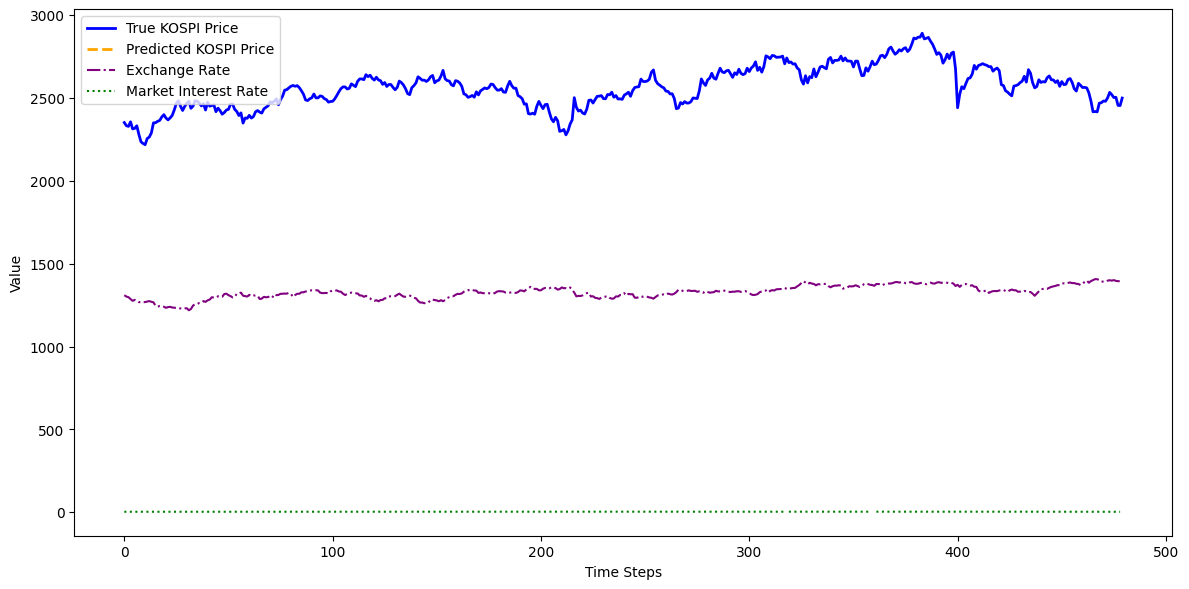

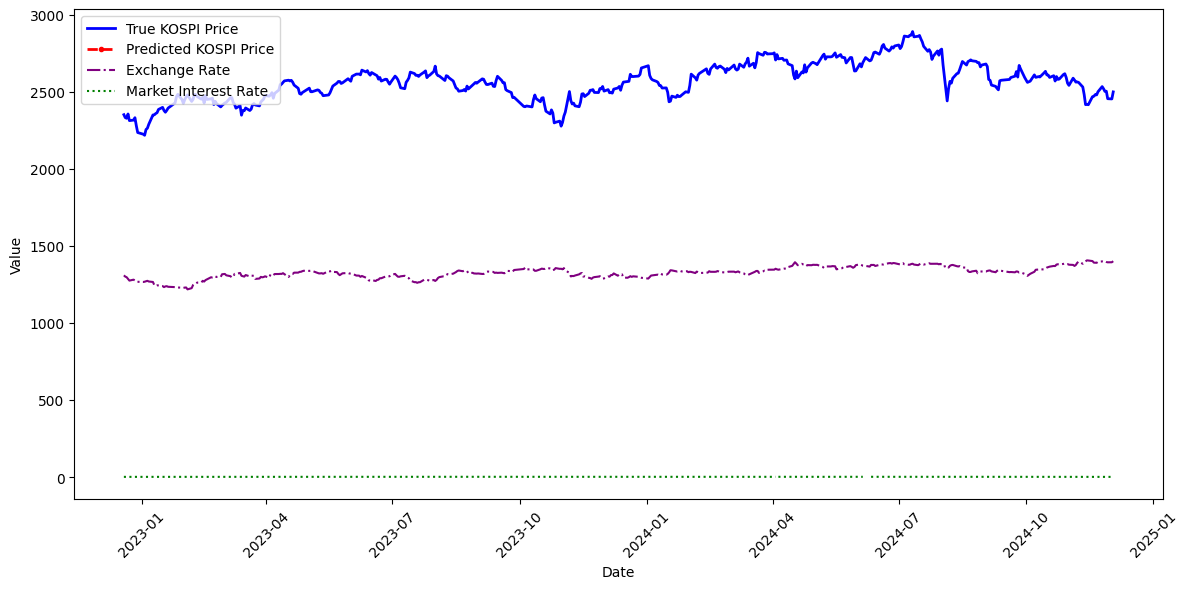

In [ ]:
# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[['Exchange_Rate', 'Closing_Price', 'Interest_Rate', 'Economic_Sentiment_Index']])

# LSTM 입력 준비 (이전 10일 데이터를 사용하여 다음날 예측)
X, y = [], []
for i in range(10, len(scaled_data)):
    X.append(scaled_data[i-10:i])
    y.append(scaled_data[i, 1])  # KOSPI 지수 예측 (Interest_Rate 및 경제 심리지수도 영향을 받음)

X, y = np.array(X), np.array(y)

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=30, batch_size=32)

# 예측 결과 스케일 역변환
predictions = model.predict(X)
rescaled_data = scaler.inverse_transform(scaled_data[10:])
true_y_rescaled = rescaled_data[:, 1]
predictions_rescaled = scaler.inverse_transform(np.concatenate((scaled_data[10:, :1], predictions, scaled_data[10:, 2:]), axis=1))[:, 1]
exchange_rate_rescaled = rescaled_data[:, 0]
interest_rate_rescaled = rescaled_data[:, 2]
economic_sentiment_rescaled = rescaled_data[:, 3]

# 예측 결과 시각화 (모든 변수 포함, 상세한 변동성을 확인하기 위해 확대)
plt.figure(figsize=(16, 8))
plt.plot(range(len(true_y_rescaled)), true_y_rescaled, label='True KOSPI Price', linestyle='-', linewidth=2, color='blue')
plt.plot(range(len(predictions_rescaled)), predictions_rescaled, label='Predicted KOSPI Price', linestyle='--', linewidth=2, color='orange')
plt.plot(range(len(exchange_rate_rescaled)), exchange_rate_rescaled, label='Exchange Rate', linestyle='-.', linewidth=1.5, color='purple')
plt.plot(range(len(interest_rate_rescaled)), interest_rate_rescaled, label='Market Interest Rate', linestyle=':', linewidth=1.5, color='green')
plt.plot(range(len(economic_sentiment_rescaled)), economic_sentiment_rescaled, label='Economic Sentiment Index', linestyle='-', linewidth=1.5, color='red')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# lstm_modeling.py

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# 데이터 병합 및 전처리
exchange_rate_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/processed_exchange_rate_data.csv")
kospi_data_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/processed_kospi_data.csv")
market_interest_rate = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/raw_data/market_interest_rate_221203_241203.csv")

# 컬럼명 변경 (만약 필요한 경우)
market_interest_rate.columns = ['Date', 'Interest_Rate']

# Date 컬럼을 datetime 형식으로 변환
exchange_rate_df['Date'] = pd.to_datetime(exchange_rate_df['Date'])
kospi_data_df['Date'] = pd.to_datetime(kospi_data_df['Date'])
market_interest_rate['Date'] = pd.to_datetime(market_interest_rate['Date'])

# 데이터 병합
merged_df = pd.merge(pd.merge(exchange_rate_df, kospi_data_df, on='Date', how='inner'), market_interest_rate, on='Date', how='inner')
merged_df = merged_df.sort_values(by='Date')

# 각 변수별로 개별 스케일러 사용
exchange_rate_scaler = MinMaxScaler(feature_range=(0, 1))
closing_price_scaler = MinMaxScaler(feature_range=(0, 1))
interest_rate_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_exchange_rate = exchange_rate_scaler.fit_transform(merged_df[['Exchange_Rate']])
scaled_closing_price = closing_price_scaler.fit_transform(merged_df[['Closing_Price']])
scaled_interest_rate = interest_rate_scaler.fit_transform(merged_df[['Interest_Rate']])

# 데이터 결합
scaled_data = np.concatenate((scaled_exchange_rate, scaled_closing_price, scaled_interest_rate), axis=1)

# LSTM 입력 준비 (이전 10일 데이터를 사용하여 다음날 예측)
X, y = [], []
for i in range(10, len(scaled_data)):
    X.append(scaled_data[i-10:i])
    y.append(scaled_closing_price[i])  # KOSPI 지수 예측

X, y = np.array(X), np.array(y)

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=30, batch_size=32)

# 예측 결과 스케일 역변환
predictions = model.predict(X)
predictions_rescaled = closing_price_scaler.inverse_transform(predictions)

# 예측 결과 시각화 (모든 변수 포함)
plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), closing_price_scaler.inverse_transform(y), label='True KOSPI Price', linestyle='-', linewidth=2, color='blue')
plt.plot(range(len(predictions_rescaled)), predictions_rescaled, label='Predicted KOSPI Price', linestyle='--', linewidth=2, color='orange')
plt.plot(range(len(scaled_exchange_rate[10:])), exchange_rate_scaler.inverse_transform(scaled_exchange_rate[10:]), label='Exchange Rate', linestyle='-.', linewidth=1.5, color='purple')
plt.plot(range(len(scaled_interest_rate[10:])), interest_rate_scaler.inverse_transform(scaled_interest_rate[10:]), label='Market Interest Rate', linestyle=':', linewidth=1.5, color='green')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()